In [40]:
#first let's check how epsilon-greedy approach will look like
#but first libraries

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
#machine class
class Machine:
    def __init__(self, mu, sigma_square):
        self.mu = mu
        self.sigma = np.sqrt(sigma_square)
        self.avg_reward = 0

    def give_reward(self):
        return np.random.normal(self.mu, self.sigma)
    
#class Player
class Player():
    def __init__(self, num_games, machines, epsilon):
        self.num_games = num_games
        self.machines = machines
        self.epsilon = epsilon
        self.avg_reward = 0
        self.avg_lists_gathered= None
    
    def play_games(self):
        fav_machine_index = None
        best_reward = None

        #sprawdzamy, ktory automat jest naszym ulubionym(na poczatek)
        for i in range(len(self.machines)):
            machine = self.machines[i]
            reward = machine.give_reward()
            machine.avg_reward = reward

            if best_reward is None or reward > best_reward:
                best_reward = reward
                fav_machine_index = i
                self.avg_reward= reward
                
                if self.avg_lists_gathered is None:
                    self.avg_lists_gathered= [reward]
                else:
                    self.avg_lists_gathered[0]= reward

        #we do not consider these(upper) games as an actual games

        for i in range(2, self.num_games +1):
            random_choice = np.random.choice([1, 0], p=[self.epsilon, 1 - self.epsilon]) #if 1 then exploration, 0 explotation

            if random_choice==1:
                #take random machine:
                random_machine_index= np.random.randint(0, 10)
                
                exploit_machine= self.machines[random_machine_index]
                getting_reward= exploit_machine.give_reward()

            else:
                #take your favourite machine
                exploit_machine= self.machines[fav_machine_index]
                getting_reward= exploit_machine.give_reward()
                
            #update avg reward for machine
            prev_sum= exploit_machine.avg_reward * (i-1)
            exploit_machine.avg_reward= (prev_sum +getting_reward )/ i

            #update avg reward for player
            prev_sum_player= self.avg_reward * (i-1)
            self.avg_reward= (prev_sum_player+getting_reward)/i

            #appending last avg_reward
            self.avg_lists_gathered.append(self.avg_reward)


            #check which machine is your favourite
            for i in range(10):
                    c_machine= self.machines[i]
                    if c_machine.avg_reward > self.machines[fav_machine_index].avg_reward:
                        fav_machine_index= i



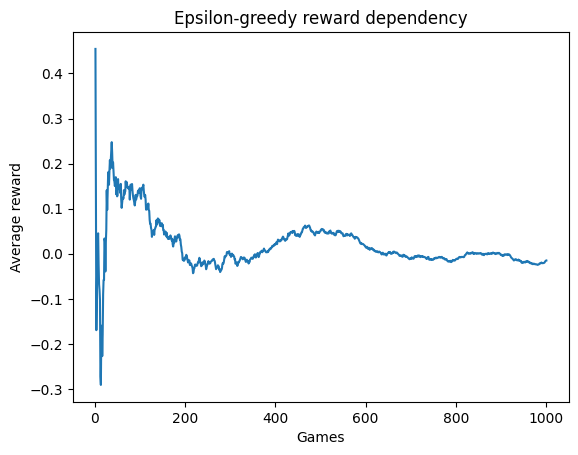

In [54]:
#creating machines
machines= [Machine(0.1, 1)]

for i in range(9):
    machines.append(Machine(0, 1))

#our assumption the first game is like checking all the machines which suits as the best(not sure if right way of thinking), in the rest games, we can check only one machine in a time
#but during the first game(first time), like in one unit of time we are checking all the machines
    
player= Player(1000, machines, 0.1)

#playing games
player.play_games()


#now the most crucial thing, we do not consider first observation as it is not really accurate, and the way machine took "best machine" at first step is rather artificial
games_axes= range(2, 1001)
results= player.avg_lists_gathered[1:]

df = pd.DataFrame(list(zip(games_axes, results)), columns=['X', 'Y'])

lineplot= sns.lineplot(data=df, x='X', y='Y')

lineplot.set_xlabel('Games')
lineplot.set_ylabel('Average reward')
lineplot.set_title('Epsilon-greedy reward dependency')

plt.show()

In [59]:
#now let's consider UCB-approach

#we have to change the behaviour of the player, as well as the machines

#machine UCB class
class MachineUCB(Machine):
    def __init__(self, mu, sigma_square):
        super().__init__(mu, sigma_square)
        self.played= 0 #information how many times the machine has been choosed

class PlayerUCB():
    def __init__(self, num_games, machines, c):
        self.num_games = num_games
        self.machines = machines
        self.c = c
        self.avg_reward = 0
        self.avg_lists_gathered= None

    #first-game similar as in the epsilon-greedy approach, 
    def play_games(self):
        best_reward = None

        #sprawdzamy, ktory automat jest naszym ulubionym(na poczatek)
        for i in range(len(self.machines)):
            machine = self.machines[i]
            reward = machine.give_reward()
            machine.avg_reward = reward #now all rewards will have set some initial value
            machine.played=1 #we have one time played on every machine

            if best_reward is None or reward > best_reward:
                best_reward = reward
                self.avg_reward= reward #we have set the best reward to our first step
                
                if self.avg_lists_gathered is None:
                    self.avg_lists_gathered= [reward]
                else:
                    self.avg_lists_gathered[0]= reward

        #we do not consider these(upper) games as an actual games

        for i in range(2, self.num_games +1):
            best_index=0
            highest_value= None

            for j in range(len(self.machines)):
                machine= self.machines[j]
                played_times= machine.played
                machine_avg= machine.avg_reward

                machine_value= machine_avg+ self.c * np.sqrt(np.log(i)/played_times)

                if highest_value is None:
                    best_index= j
                    highest_value= machine_value
                else:
                    if machine_value > highest_value:
                        best_index= j
                        highest_value= machine_value
            
            best_machine= self.machines[best_index]
            reward= best_machine.give_reward()

            #update avg reward for machine
            prev_sum= best_machine.avg_reward * (i-1)
            best_machine.avg_reward= (prev_sum +reward )/ i

            #update avg reward for player
            prev_sum_player= self.avg_reward * (i-1)
            self.avg_reward= (prev_sum_player+reward)/i

            #appending last avg_reward
            self.avg_lists_gathered.append(self.avg_reward)
            



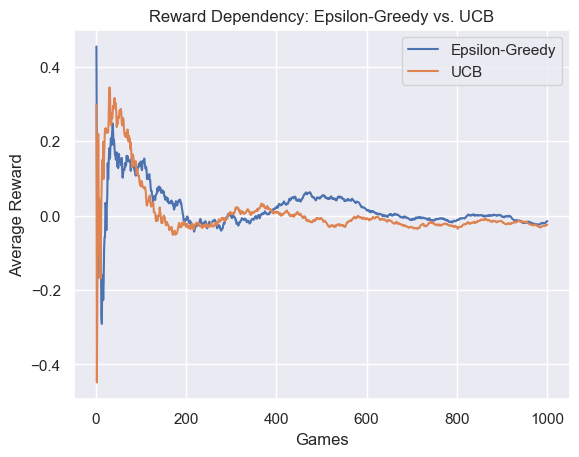

In [62]:
#creating machines
machinesUCB= [MachineUCB(0.1, 1)]

for i in range(9):
    machinesUCB.append(MachineUCB(0, 1))

#our assumption the first game is like checking all the machines which suits as the best(not sure if right way of thinking), in the rest games, we can check only one machine in a time
#but during the first game(first time), like in one unit of time we are checking all the machines
    
playerUCB= PlayerUCB(1000, machinesUCB, 2)

#playing games
playerUCB.play_games()


#now the most crucial thing, we do not consider first observation as it is not really accurate, and the way machine took "best machine" at first step is rather artificial
games_axesUCB= range(2, 1001)
resultsUCB= playerUCB.avg_lists_gathered[1:]

df2 = pd.DataFrame(list(zip(games_axesUCB, resultsUCB)), columns=['X', 'Y'])

sns.set(style="darkgrid")

fig, ax = plt.subplots()

sns.lineplot(data=df, x='X', y='Y', ax=ax, label='Epsilon-Greedy')
sns.lineplot(data=df2, x='X', y='Y', ax=ax, label='UCB')

ax.set_xlabel('Games')
ax.set_ylabel('Average Reward')
ax.set_title('Reward Dependency: Epsilon-Greedy vs. UCB')

ax.legend()
plt.show()